In [1]:
import wandb
import os,sys,shutil
import networkx as nx
import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pdb

ENTITY_NAME = "yuxinma"
PROJECT_NAME = "planted_clique_v1"
CURRENT_DIR = os.getcwd()
sys.path.append(os.path.dirname(os.path.dirname(CURRENT_DIR)))
from train import GNN


Bad key "text.kerning_factor" on line 4 in
/home/tim/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import tkmath

tkmath.mpl_util.init_latex()

In [3]:
wandb.login()

wandb: Currently logged in as: kunisky (yuxinma). Use `wandb login --relogin` to force relogin


True

In [4]:
ENTITY_NAME = "yuxinma"
PROJECT_NAME = "planted_clique_v1"

In [5]:
def download_best_model(run_id):
    """ Download from wandb logs the model checkpoint and its config"""
    #download the best model checkpoint
    api = wandb.Api()
    artifact = api.artifact(f"{ENTITY_NAME}/{PROJECT_NAME}/model-{run_id}:best")  #download the best_model
    best_ckpt = artifact.download(root = os.path.join(CURRENT_DIR, "downloaded_artifact"))
    best_ckpt = os.path.join(best_ckpt, "model.ckpt")
    best_model = GNN.load_from_checkpoint(best_ckpt, map_location=None)

    #get the run config
    run = api.run(f"{ENTITY_NAME}/{PROJECT_NAME}/{run_id}")
    config = run.config

    #clean up
    shutil.rmtree(os.path.dirname(best_ckpt))
    return best_model, config

In [76]:
good_models = ["qnukcpt2", "7hpvy9yq", "zoucqvma", "0fqxnmrl"]
bad_models = ["9wy9kmni", "pona72xj", "ywvugdpp", "mdhukrsw", "gcmjv3so", "6a5pjiq3"]

run_id = good_models[3]

# run_id = 'yuxinma/planted_clique_v1/n39cx1ch'.split('/')[-1]  # good (no diag)

model, config = download_best_model(run_id)
model.eval()

wandb:   1 of 1 files downloaded.  


GNN(
  (model): equiv_GNN(
    (equiv_layers): ModuleList(
      (0): layer_2_to_2()
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): layer_2_to_2()
      (4): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Dropout2d(p=False, inplace=False)
      (7): layer_2_to_2()
    )
    (head): Linear(in_features=1, out_features=1, bias=True)
  )
  (bce_logit): BCEWithLogitsLoss()
  (mse): MSELoss()
  (accuracy): Accuracy()
  (precision): Precision()
  (recall): Recall()
)

In [77]:
n = 1000

adj_matrix = tkmath.graphs.random.erdos_renyi(n, 0.5)
adj_matrix = (adj_matrix - adj_matrix.mean()) / (adj_matrix.std()+1e-8)
# adj_matrix = tkmath.graphs.random.planted_clique(n, 0.5, int(1.5 * np.sqrt(n)))
A, p = model.model(torch.tensor(adj_matrix).unsqueeze(0).float())
out_np = A.squeeze().detach().cpu().numpy()

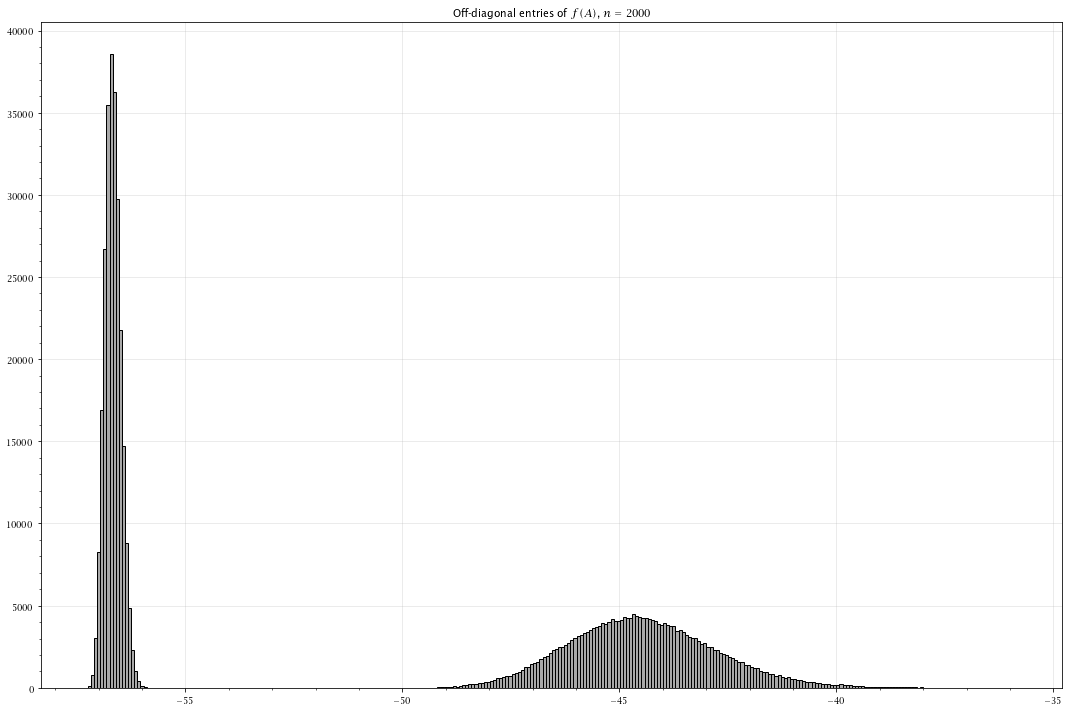

In [78]:
plt.subplots(figsize=(15, 10))

tkmath.mpl_util.init_latex()

_ = plt.hist(tkmath.linalg.offdiag_vec(out_np + out_np.T), bins=300, **tkmath.mpl_util.HISTOGRAM_KWARGS)

tkmath.mpl_util.style_ax(plt.gca())

plt.title('Off-diagonal entries of $f(A)$, $n = 2000$')

plt.tight_layout()
# plt.savefig('/home/tim/Downloads/entry-hist-good-run.pdf')

In [69]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor])

model.equiv_layers.0.coeffs 	 tensor([[[-0.3288,  0.2493,  0.5163, -0.0344, -0.0321,  0.3136,  0.5477,
           0.0493, -0.1232,  0.2725, -0.2936, -0.2803,  0.1455,  0.0983,
           0.1433],
         [-0.0756,  0.0467,  0.2105, -0.1068,  0.0050, -0.0268, -0.1917,
           0.1585, -0.0621, -0.4497,  0.0303,  0.2507,  0.0853, -0.0400,
           0.3343],
         [ 0.1145,  0.3345,  0.0747,  0.1207, -0.1880,  0.1368, -0.0986,
           0.3554, -0.0537,  0.0713,  0.0250, -0.3476, -0.2461,  0.3939,
           0.2145],
         [-0.0605,  0.0477, -0.0050,  0.0999, -0.2213,  0.2911,  0.3479,
          -0.3597,  0.2120,  0.1757, -0.0678, -0.0591,  0.0298,  0.0489,
           0.8449],
         [-0.1174,  0.0477,  0.0816, -0.3092,  0.9109, -0.0222, -0.1293,
           0.2090, -0.0342, -0.2125,  0.1506,  0.0926, -0.2159, -0.1309,
           1.4075]]])
model.equiv_layers.0.diag_bias 	 tensor([[[[ 0.0623]],

         [[ 0.0523]],

         [[-0.0635]],

         [[-0.0376]],

         [[ 0

In [13]:
n = 100

adj_matrix = tkmath.graphs.random.erdos_renyi(n, 0.5)
# adj_matrix = tkmath.graphs.random.planted_clique(n, 0.5, int(1.5 * np.sqrt(n)))
A, p = model.model(torch.tensor(adj_matrix).unsqueeze(0).float())
out_np = A.squeeze().detach().cpu().numpy()

In [46]:
out_np

array([[39.48047 , 95.67122 , 97.44013 , ..., 95.67105 , 99.452194,
        96.275635],
       [95.67122 , 38.613163, 96.90976 , ..., 97.24437 , 96.62601 ,
        97.85445 ],
       [97.44013 , 96.90976 , 41.12949 , ..., 96.90958 , 98.05028 ,
        97.43756 ],
       ...,
       [95.67105 , 97.24437 , 96.90958 , ..., 38.612843, 98.85724 ,
        95.668564],
       [99.452194, 96.62601 , 98.05028 , ..., 98.85724 , 40.76576 ,
        99.449684],
       [96.275635, 97.85445 , 97.43756 , ..., 95.668564, 99.449684,
        39.474346]], dtype=float32)

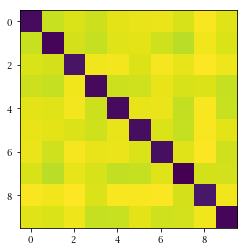

In [47]:
plt.imshow(out_np[:10, :][:, :10])

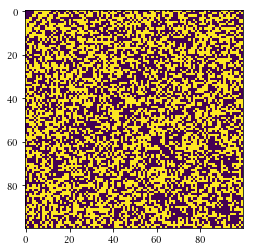

In [48]:
plt.imshow(adj_matrix)

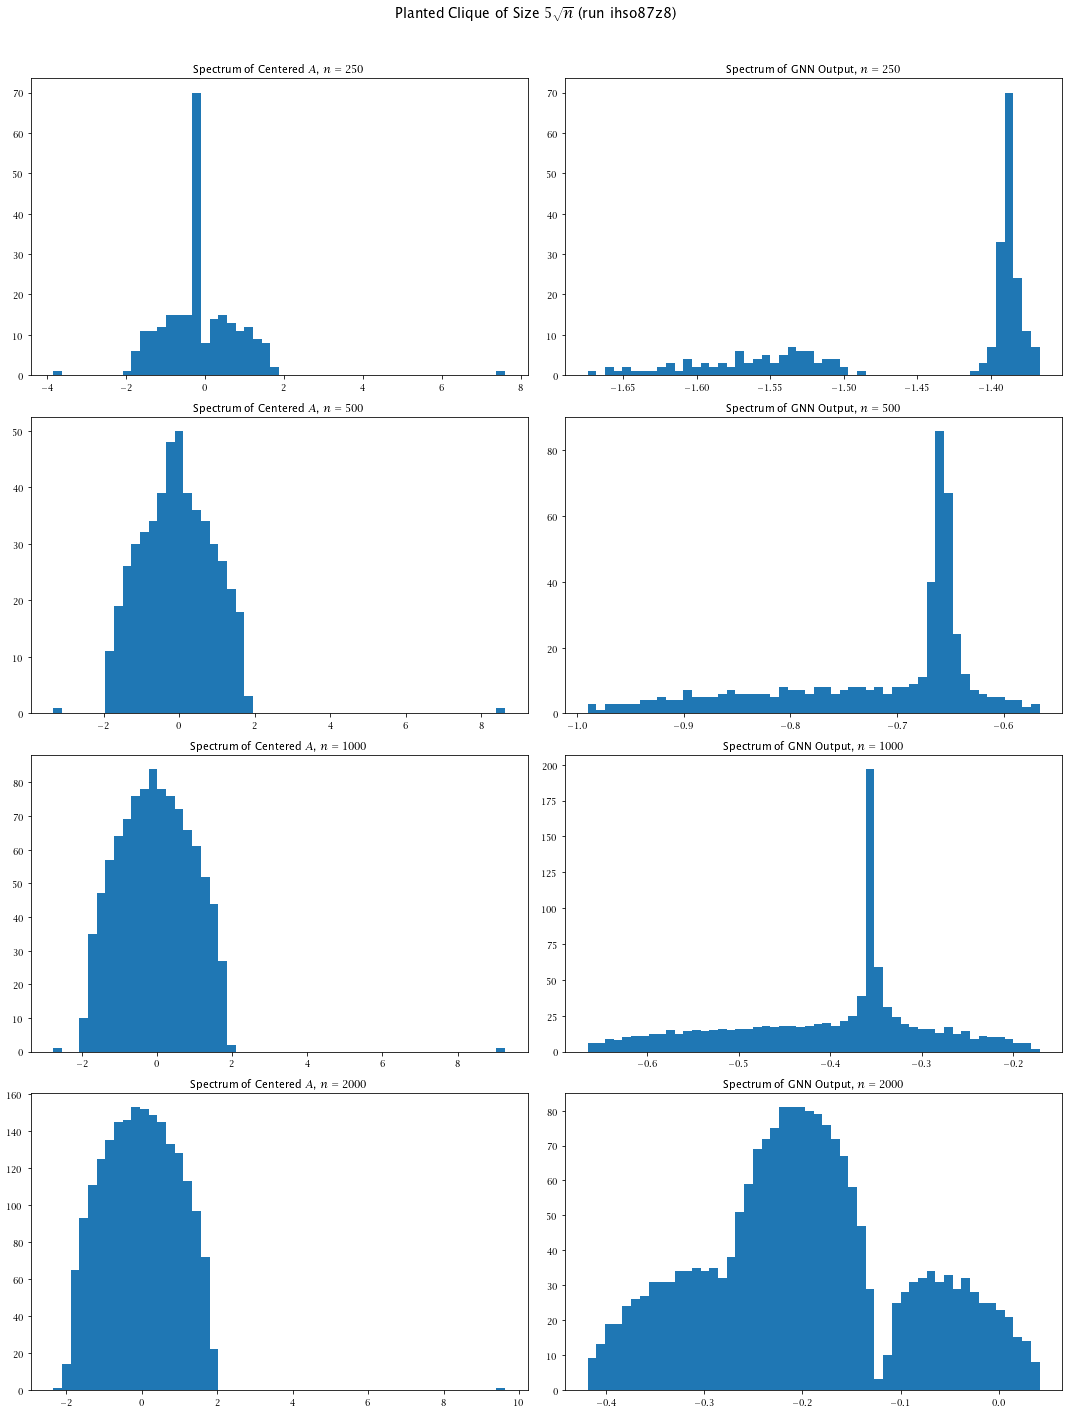

In [21]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for i, n in enumerate([250, 500, 1000, 2000]):
    # adj_matrix = tkmath.graphs.random.erdos_renyi(n, 0.5)
    adj_matrix = tkmath.graphs.random.planted_clique(n, 0.5, int(10 * np.sqrt(n)))
    eps = 1e-8
    adj_matrix = (adj_matrix - adj_matrix.mean()) / (adj_matrix.std()+eps)
    
    A, p = model.model(torch.tensor(adj_matrix).unsqueeze(0).float())
    out_np = A.squeeze().detach().cpu().numpy()
    
    _ = axes[i][0].hist(np.linalg.eigvalsh(adj_matrix) / np.sqrt(n), bins=52)
    axes[i][0].set_title('Spectrum of Centered $A$, $n = %d$' % n)

    _ = axes[i][1].hist(np.linalg.eigvalsh(out_np)[2:-2]  / np.sqrt(n), bins=52)
    axes[i][1].set_title('Spectrum of GNN Output, $n = %d$' % n)
    
fig.suptitle('Planted Clique of Size $5\\sqrt{n}$ (run %s)' % run_id, fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# plt.savefig('/home/tim/Downloads/planted-clique_spectrum_large-clique.pdf')

Preliminary observation: seems to be strong finite size effect in shape of spectrum of output matrix, starting out as "triangle" but then tending to semicircle for large $n$...

In [49]:
n = 200
m = 10

As = [tkmath.graphs.random.erdos_renyi(n, 0.5) for _ in range(m)]
As.extend([tkmath.graphs.random.planted_clique(n, 0.5, int(1.5 * np.sqrt(n)))])

E1 = lambda A: A
E2 = lambda A: np.diag(A @ np.ones(n))
E3 = lambda A: np.eye(n)
E4 = lambda A: np.ones((n, n))
Es = [E1, E2, E3, E4]

k = 4

Gram = np.zeros((k, k))
ATb = np.zeros(k)

for i in range(k):
    for j in range(k):
        Gram[i, j] = sum(np.trace(Es[i](As[l]) @ Es[j](As[l])) for l in range(m))
    
    for l in range(m):
        eps = 1e-8
        adj_matrix = (As[l] - As[l].mean()) / (As[l].std() + eps)
        A, p = model.model(torch.tensor(adj_matrix).unsqueeze(0).float())
        out_np = A.squeeze().detach().cpu().numpy()
    
        ATb[i] += np.trace(Es[i](As[l]) @ out_np)

In [50]:
cs = np.linalg.solve(Gram, ATb)
print(cs)

[  1.77548556  -0.09292856 -13.91812214  -8.60160502]


In [51]:
total_err = 0
total_norm = 0

for l in range(m):
    adj_matrix = (As[l] - As[l].mean()) / (As[l].std() + eps)
    A, p = model.model(torch.tensor(adj_matrix).unsqueeze(0).float())
    out_np = A.squeeze().detach().cpu().numpy()
    
    pred = sum(cs[j] * Es[j](As[l]) for j in range(k))
    
    total_err += np.sum((out_np - pred) ** 2)
    total_norm += np.sum(out_np ** 2)
    
print(total_err / total_norm)

0.008184964210191206


In [42]:
print(run_id, cs)

ihso87z8 [-1.22571019 -0.08984911  2.8947638  -6.04835426]


In [52]:
print(run_id, cs)

v0b2lc4i [  1.77548556  -0.09292856 -13.91812214  -8.60160502]


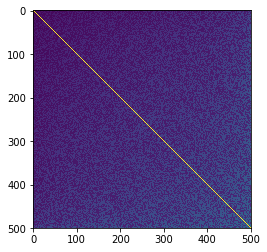

In [112]:
degs = adj_matrix @ np.ones(n)
degs_order = np.argsort(degs)
plt.imshow((out_np - np.diag(np.diag(out_np)))[degs_order, :][:, degs_order])

In [113]:
evals, evecs = np.linalg.eigh(adj_matrix)

In [117]:
adj_mx_mod = evecs[:, :-1] @ np.diag(evals[:-1]) @ evecs[:, :-1].T

(array([ 3.,  7.,  4.,  6.,  8.,  8.,  9.,  9., 10.,  9., 11., 10., 12.,
        10., 13., 10., 13., 11., 13., 13., 12., 13., 13., 13., 11., 15.,
        13., 12., 13., 13., 12., 12., 11., 13., 13., 11., 11., 12., 10.,
        11., 10.,  9.,  9.,  7.,  9.,  7.,  6.,  5.,  4.,  1.]),
 array([-22.65273068, -21.75759638, -20.86246207, -19.96732777,
        -19.07219347, -18.17705917, -17.28192486, -16.38679056,
        -15.49165626, -14.59652196, -13.70138765, -12.80625335,
        -11.91111905, -11.01598475, -10.12085044,  -9.22571614,
         -8.33058184,  -7.43544754,  -6.54031323,  -5.64517893,
         -4.75004463,  -3.85491033,  -2.95977602,  -2.06464172,
         -1.16950742,  -0.27437312,   0.62076119,   1.51589549,
          2.41102979,   3.30616409,   4.2012984 ,   5.0964327 ,
          5.991567  ,   6.8867013 ,   7.78183561,   8.67696991,
          9.57210421,  10.46723851,  11.36237282,  12.25750712,
         13.15264142,  14.04777572,  14.94291003,  15.83804433,
         16.

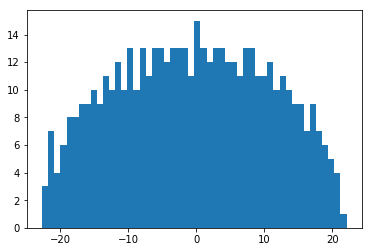

In [120]:
plt.hist(np.linalg.eigvalsh(adj_mx_mod), bins=50)